In [1]:
# Set display width, load packages, import symbols
ENV["COLUMNS"]=72
using Distributions
using Interpolations
using Knet: Knet, dir, accuracy, progress, sgd, load143, save, gc, Param, KnetArray, Data, minibatch, nll, relu, training, dropout,sigm # param, param0, xavier_uniform
using Knet
using Images
using Plots
using LinearAlgebra
using IterTools: ncycle, takenth
using MLDatasets
using Base.Iterators: flatten
import CUDA # functional
using ImageTransformations
using Statistics
using Memento
using NPZ
# using Interpolations
atype=(CUDA.functional() ? KnetArray{Float32} : Array{Float32})

KnetArray{Float32, N} where N

In [2]:
pwd()

"/scratch/users/bbozkurt15/MyJulia/GON_Project_Deployables/Evaluation_Notebook"

In [3]:
cd("..")

In [4]:
const F = Float32
params = Knet.params

logger = Memento.config!("info"; fmt="[{date} | {level} | {name}]: {msg}");

include("PlotUtility.jl")
include("ImageUtility.jl")
include("TrainUtility.jl")
include("LayerUtility.jl")
include("LossUtility.jl")

using .PlotUtility
using .ImageUtility
using .TrainUtility
using .LayerUtility
using .LossUtility

In [5]:
dataset_name = "mnist"
use_saved_data = false
nc = nothing

if dataset_name == "mnist"
    nc = 1
    if use_saved_data
        xtrn = npzread("Data/MNIST_Train_Images.npy")
        xtrn = permutedims(xtrn, (3,4,2,1))
        xtst = npzread("Data/MNIST_Test_Images.npy")
        xtst = permutedims(xtst, (3,4,2,1))

    else

        xtrn,_ = MNIST.traindata()
        xtst,_ = MNIST.testdata()
        xtrn = Array{Float64, 3}(xtrn)
        xtst = Array{Float64, 3}(xtst)

        xtrn = resize_MNIST(xtrn, 1)
        xtst = resize_MNIST(xtst, 1)
        
    end
    
elseif dataset_name == "fashion"
    nc = 1
    if use_saved_data

        xtrn = npzread("Data/Fashion_MNIST_Train_Images.npy")
        xtrn = permutedims(xtrn, (3,4,2,1))
        xtst = npzread("Data/Fashion_MNIST_Test_Images.npy")
        xtst = permutedims(xtst, (3,4,2,1))
        
    else
        
        xtrn,_ = FashionMNIST.traindata()
        xtst,_ = FashionMNIST.testdata()
        xtrn = Array{Float64, 3}(xtrn)
        xtst = Array{Float64, 3}(xtst)

        xtrn = resize_MNIST(xtrn, 1)
        xtst = resize_MNIST(xtst, 1)

    end
    
elseif dataset_name == "cifar"
    nc = 3
    xtrn,_= CIFAR10.traindata()
    xtst,_ = CIFAR10.testdata()
    xtrn = Array{Float64, 4}(xtrn)
    xtst = Array{Float64, 4}(xtst)
#     println("No implemented yet")
end

batch_size = 64

dtrn = minibatch(xtrn, batch_size; xsize = (28*28, nc,:), xtype = atype, shuffle = true)
dtst = minibatch(xtst, batch_size; xsize = (28*28, nc,:), xtype = atype);

# Implicit GON : MNIST

In [6]:
results_path = "./Results/Implicit_GON_MNIST_mnist1"
model_path = joinpath(results_path, "Saved_Models")

"./Results/Implicit_GON_MNIST_mnist1/Saved_Models"

In [7]:
readdir(results_path)

5-element Vector{String}:
 "Images"
 "Logger"
 "Saved_Models"
 "trn_loss_list.jld2"
 "tst_loss_list.jld2"

In [8]:
readdir(model_path)

2-element Vector{String}:
 "Model_Base1050.jld2"
 "Model_Base1100.jld2"

In [9]:
trn_loss_list = Knet.load(joinpath(results_path,"trn_loss_list.jld2"), )["trn_loss_list"]
tst_loss_list = Knet.load(joinpath(results_path,"tst_loss_list.jld2"), )["tst_loss_list"]


trn_loss_list[end], tst_loss_list[end]

(0.00518794683739543, 0.005230918526649475)

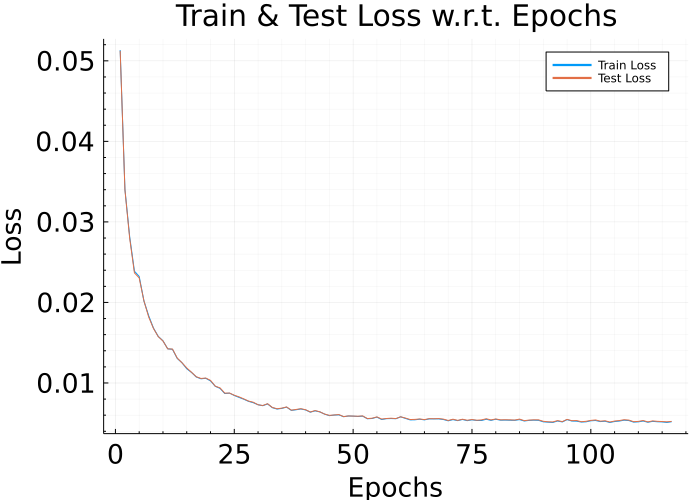

In [10]:
plot_loss_convergence(trn_loss_list[2:end], tst_loss_list[2:end], title = "Train & Test Loss w.r.t. Epochs")

In [11]:
theta = value.(Knet.load(joinpath(model_path,"Model_Base1100.jld2"), )["model"][:decoder])

10-element Vector{Knet.KnetArrays.KnetMatrix{Float32}}:
 K32(256,34)[0.00020842107⋯]
 K32(256,1)[-0.10390528⋯]
 K32(256,256)[-0.033501294⋯]
 K32(256,1)[-0.08482959⋯]
 K32(256,256)[0.0058780313⋯]
 K32(256,1)[-0.03310648⋯]
 K32(256,256)[0.0015058415⋯]
 K32(256,1)[0.0077237366⋯]
 K32(1,256)[0.0041683214⋯]
 K32(1,1)[0.34843343⋯]

In [12]:
function get_mgrid(sidelen)
    iterator = (range(-1,stop=1,length = sidelen))
    return Array{Float64}(hcat([[i,j] for i = iterator, j = iterator]...)');
end

function batched_linear(theta, x_in; atype = KnetArray{Float32})
#     """
#     multiply a weight matrix of size (O, I) with a batch of matrices 
#     of size (I, W, B) to have an output of size (O, W, B), 
#     where B is the batch size.
    
#     size(theta) = (O, I)
#     size(x_in) = (O, W, B)
#     """
    o = size(theta,1)
    w = size(x_in, 2)
    b = size(x_in, 3)
    x_in_reshaped = reshape(x_in, size(x_in,1), w*b)
    out = reshape(theta * x_in_reshaped, size(theta,1), w, b)
    return out
end

function model_forw(theta, z, c; w0 = 30)
   
    z_ = copy(z)
    z_ = permutedims(reshape(z_,64,1,1,num_latent),(4,3,2,1))
    # The following line is the same for  :  hcat([z for _ = 1:size(c,2)]...)
    # However it is more efficient while taking second order derivative of the loss.
    # one_conv_weight is defined globally as convolution weights of all ones
    z_rep = permutedims(conv4(one_conv_weight, z_)[:,1,:,:], (3,2,1))
    z_in = cat(c, z_rep, dims = 3)
    z_in = (permutedims(z_in, (3,2,1)))
    z = batched_linear(theta[1], z_in) .+ theta[2]
    z = sin.(w0 .* z)
    
    z = batched_linear(theta[3], z) .+ theta[4]
    z = sin.(w0 .* z)
    
    z = batched_linear(theta[5], z) .+ theta[6]
    z = sin.(w0 .* z)
    
    z = batched_linear(theta[7], z) .+ theta[8]
    z = sin.(w0 .* z)
    
    z = batched_linear(theta[9], z) .+ theta[10]
#     z = sin.(30 .* z)
    z = permutedims(z, (2,1,3))
end

function loss(theta, z, x)
    x_hat = model_forw(theta, z, c)
    L = mean((x_hat- x).^2)
#     L = mean(sum((x_hat - x).^2, dims = 1))
end

function loss_train(theta, x; batch_size = 64)
    z = Param(atype(zeros(batch_size, 1, num_latent)))
    derivative_origin = @diff loss(theta, z, x)
    dz = grad(derivative_origin, z)
    z = -dz
    x_hat = model_forw(theta, z, c)
    L = mean((x_hat- x).^2)
#     L = mean(sum((x_hat - x).^2, dims = 1))
    return L
end

function loss_train(theta, d::Data)
     total_loss = 0
    n_instance = 0
    for x in d
        batch_size_ = size(x,3)
       total_loss += loss_train(theta, x; batch_size = batch_size_) * batch_size_
        n_instance += batch_size_
    end
    total_loss / n_instance
end

loss_train (generic function with 2 methods)

In [13]:
x = first(dtrn)

# one_conv_weight = atype(ones(1,1,1,784))

batch_size = 64
x = first(dtrn)
mgrid = get_mgrid(28)
c = atype(permutedims(repeat(mgrid,1,1,batch_size),(3,1,2)));
c_copy = copy(c)
c_copy[:,:,1] = c[:,:,2]
c_copy[:,:,2] = c[:,:,1]
c = c_copy
num_latent = 32
one_conv_weight = atype(ones(1,1,1,size(c,2)))
z = Param(atype(zeros(batch_size, 1, num_latent)))
derivative_origin = @diff loss(theta, z, x)
dz = grad(derivative_origin, z)
z = -dz
mgrid = get_mgrid(256)
c = atype(permutedims(repeat(mgrid,1,1,batch_size),(3,1,2)));
c_copy = copy(c)
c_copy[:,:,1] = c[:,:,2]
c_copy[:,:,2] = c[:,:,1]
c = c_copy
num_latent = 32
one_conv_weight = atype(ones(1,1,1,size(c,2)))

x_hat = model_forw(theta, z, c)
x_hat_ = Array{Float32}(reshape(x_hat, 256,256,1,64));

mgrid = get_mgrid(64)
c = atype(permutedims(repeat(mgrid,1,1,batch_size),(3,1,2)));
c_copy = copy(c)
c_copy[:,:,1] = c[:,:,2]
c_copy[:,:,2] = c[:,:,1]
c = c_copy
num_latent = 32
one_conv_weight = atype(ones(1,1,1,size(c,2)))

x_hat512 = model_forw(theta, z, c)
x_hat_512 = Array{Float32}(reshape(x_hat512, 64,64,1,64));

In [14]:
size(x), size(x_hat_)

((784, 1, 64), (256, 256, 1, 64))

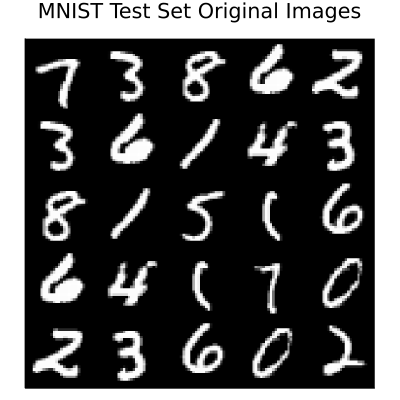

In [15]:
display(plot_image_grid(reshape(x[:,:,26:50],28,28,1,25);grid_x_size = 5, grid_y_size = 5, title = "MNIST Test Set Original Images"))
savefig("mnist_test_original")

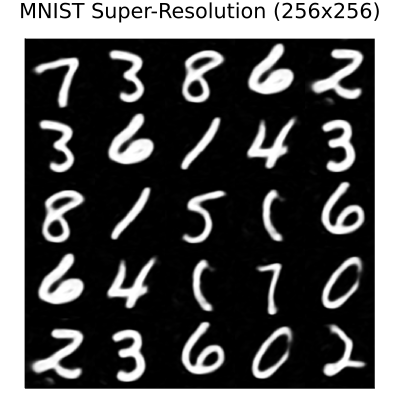

In [16]:
display(plot_image_grid(x_hat_[:,:,:,26:50];grid_x_size = 5, grid_y_size = 5, title = "MNIST Super-Resolution (256x256)"))
savefig(joinpath("Evaluation_Notebook","mnist_test_super_resolution_256"))

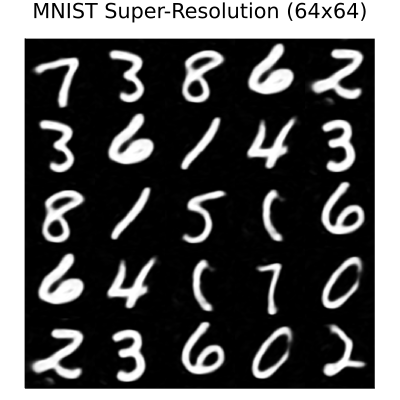

In [17]:
display(plot_image_grid(x_hat_[:,:,:,26:50];grid_x_size = 5, grid_y_size = 5, title = "MNIST Super-Resolution (64x64)"))
savefig(joinpath("Evaluation_Notebook","mnist_test_super_resolution_64"))

# Implicit GON : Fashion MNIST

In [18]:
dataset_name = "fashion"
use_saved_data = false
nc = nothing

if dataset_name == "mnist"
    nc = 1
    if use_saved_data
        xtrn = npzread("Data/MNIST_Train_Images.npy")
        xtrn = permutedims(xtrn, (3,4,2,1))
        xtst = npzread("Data/MNIST_Test_Images.npy")
        xtst = permutedims(xtst, (3,4,2,1))

    else

        xtrn,_ = MNIST.traindata()
        xtst,_ = MNIST.testdata()
        xtrn = Array{Float64, 3}(xtrn)
        xtst = Array{Float64, 3}(xtst)

        xtrn = resize_MNIST(xtrn, 1)
        xtst = resize_MNIST(xtst, 1)
        
    end
    
elseif dataset_name == "fashion"
    nc = 1
    if use_saved_data

        xtrn = npzread("Data/Fashion_MNIST_Train_Images.npy")
        xtrn = permutedims(xtrn, (3,4,2,1))
        xtst = npzread("Data/Fashion_MNIST_Test_Images.npy")
        xtst = permutedims(xtst, (3,4,2,1))
        
    else
        
        xtrn,_ = FashionMNIST.traindata()
        xtst,_ = FashionMNIST.testdata()
        xtrn = Array{Float64, 3}(xtrn)
        xtst = Array{Float64, 3}(xtst)

        xtrn = resize_MNIST(xtrn, 1)
        xtst = resize_MNIST(xtst, 1)

    end
    
elseif dataset_name == "cifar"
    nc = 3
    xtrn,_= CIFAR10.traindata()
    xtst,_ = CIFAR10.testdata()
    xtrn = Array{Float64, 4}(xtrn)
    xtst = Array{Float64, 4}(xtst)
#     println("No implemented yet")
end

batch_size = 64

dtrn = minibatch(xtrn, batch_size; xsize = (28*28, nc,:), xtype = atype, shuffle = true)
dtst = minibatch(xtst, batch_size; xsize = (28*28, nc,:), xtype = atype);

In [19]:
results_path = "./Results/Implicit_GON_Fashion_fashion1"
model_path = joinpath(results_path, "Saved_Models")

"./Results/Implicit_GON_Fashion_fashion1/Saved_Models"

In [20]:
trn_loss_list = Knet.load(joinpath(results_path,"trn_loss_list.jld2"), )["trn_loss_list"]
tst_loss_list = Knet.load(joinpath(results_path,"tst_loss_list.jld2"), )["tst_loss_list"]


trn_loss_list[end], tst_loss_list[end]

(0.008526389487087727, 0.008748039603233337)

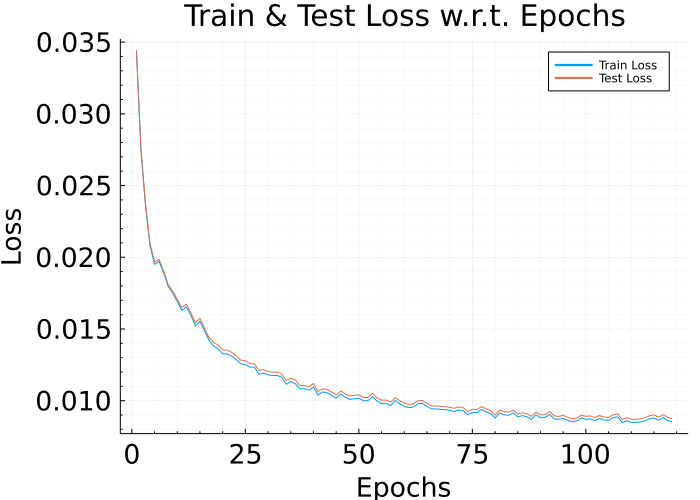

In [21]:
plot_loss_convergence(trn_loss_list[2:end], tst_loss_list[2:end], title = "Train & Test Loss w.r.t. Epochs")

In [22]:
theta = value.(Knet.load(joinpath(model_path,"Model_Base1100.jld2"), )["model"][:decoder])

10-element Vector{Knet.KnetArrays.KnetMatrix{Float32}}:
 K32(256,34)[0.00014873735⋯]
 K32(256,1)[-0.10501219⋯]
 K32(256,256)[-0.014096072⋯]
 K32(256,1)[0.009630475⋯]
 K32(256,256)[-0.0018376083⋯]
 K32(256,1)[-0.006732578⋯]
 K32(256,256)[0.003670615⋯]
 K32(256,1)[0.042229243⋯]
 K32(1,256)[0.0024756233⋯]
 K32(1,1)[0.21930023⋯]

In [23]:
x = first(dtrn)

# one_conv_weight = atype(ones(1,1,1,784))

batch_size = 64
x = first(dtrn)
mgrid = get_mgrid(28)
c = atype(permutedims(repeat(mgrid,1,1,batch_size),(3,1,2)));
c_copy = copy(c)
c_copy[:,:,1] = c[:,:,2]
c_copy[:,:,2] = c[:,:,1]
c = c_copy
num_latent = 32
one_conv_weight = atype(ones(1,1,1,size(c,2)))
z = Param(atype(zeros(batch_size, 1, num_latent)))
derivative_origin = @diff loss(theta, z, x)
dz = grad(derivative_origin, z)
z = -dz
mgrid = get_mgrid(256)
c = atype(permutedims(repeat(mgrid,1,1,batch_size),(3,1,2)));
c_copy = copy(c)
c_copy[:,:,1] = c[:,:,2]
c_copy[:,:,2] = c[:,:,1]
c = c_copy
num_latent = 32
one_conv_weight = atype(ones(1,1,1,size(c,2)))

x_hat = model_forw(theta, z, c)
x_hat_ = Array{Float32}(reshape(x_hat, 256,256,1,64));

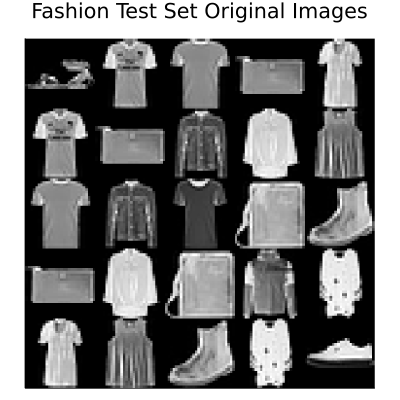

In [24]:
display(plot_image_grid(reshape(x[:,:,26:50],28,28,1,25);grid_x_size = 5, grid_y_size = 5, title = "Fashion Test Set Original Images"))
savefig(joinpath("Evaluation_Notebook","fashion_test_original"))

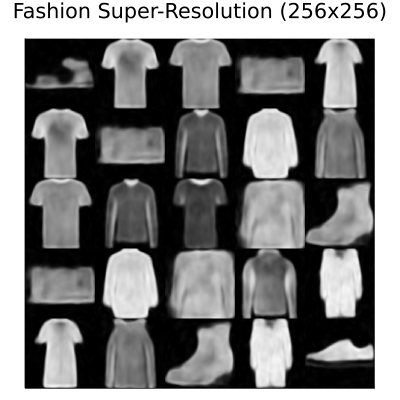

In [25]:
display(plot_image_grid(x_hat_[:,:,:,26:50];grid_x_size = 5, grid_y_size = 5, title = "Fashion Super-Resolution (256x256)"))
savefig(joinpath("Evaluation_Notebook","fashion_test_super_resolution_256"))

# Implicit GON : COIL-20

In [26]:
using Random

In [27]:
coil_path = "Data/coil20"

function load_coil_dataset(coil_path; nx = 128, nz = 128)
    image_names = readdir(coil_path)
    n_images = length(image_names)
    images = Array{Float64}(zeros(128,128, n_images))
    for i = 1:n_images
        img = load(joinpath(coil_path, image_names[i]))
        images[:,:,i] = convert(Array{Float64}, img)
    end
    return images
end

# ################ READ AND CREATE TRAIN TEST DATA #############################
coil = load_coil_dataset(coil_path);
nc = 1
dataset_size = size(coil,3)
trn_perc = 0.8
trn_size = Int(dataset_size * trn_perc)
random_permutation = randperm(dataset_size)
trn_idx = random_permutation[1:trn_size]
tst_idx = random_permutation[trn_size + 1:end]
xtrn = coil[:,:,trn_idx]
xtrn = resize_gray_image_tensor(xtrn, 1/4)
xtst = coil[:,:,tst_idx];
xtst = resize_gray_image_tensor(xtst, 1/4)
batch_size = 64

dtrn = minibatch(xtrn, batch_size; xsize = (32* 32, nc,:), xtype = atype, shuffle = true)
dtst = minibatch(xtst, batch_size; xsize = (32* 32, nc,:), xtype = atype);

In [28]:
results_path = "./Results/Implicit_GON_COIL_coil1"
model_path = joinpath(results_path, "Saved_Models")

"./Results/Implicit_GON_COIL_coil1/Saved_Models"

In [29]:
trn_loss_list = Knet.load(joinpath(results_path,"trn_loss_list.jld2"), )["trn_loss_list"]
tst_loss_list = Knet.load(joinpath(results_path,"tst_loss_list.jld2"), )["tst_loss_list"]


trn_loss_list[end], tst_loss_list[end]

(0.007262113969773054, 0.011554235592484474)

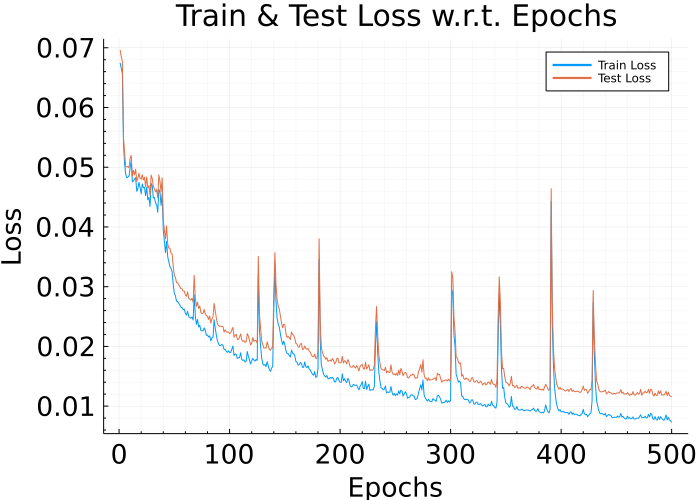

In [30]:
plot_loss_convergence(trn_loss_list[2:end], tst_loss_list[2:end], title = "Train & Test Loss w.r.t. Epochs")

In [31]:
theta = value.(Knet.load(joinpath(model_path,"Model_Base1500.jld2"), )["model"][:decoder])

10-element Vector{Knet.KnetArrays.KnetMatrix{Float32}}:
 K32(256,34)[0.023661815⋯]
 K32(256,1)[-0.012586247⋯]
 K32(256,256)[-0.0027770156⋯]
 K32(256,1)[-0.015625315⋯]
 K32(256,256)[0.0030360227⋯]
 K32(256,1)[-0.013592679⋯]
 K32(256,256)[-0.0025312828⋯]
 K32(256,1)[0.041340634⋯]
 K32(1,256)[-0.00911825⋯]
 K32(1,1)[0.024444731⋯]

In [41]:
x = first(dtrn)

# one_conv_weight = atype(ones(1,1,1,784))

batch_size = 64
x = first(dtrn)
mgrid = get_mgrid(32)
c = atype(permutedims(repeat(mgrid,1,1,batch_size),(3,1,2)));
c_copy = copy(c)
c_copy[:,:,1] = c[:,:,2]
c_copy[:,:,2] = c[:,:,1]
c = c_copy
num_latent = 32
one_conv_weight = atype(ones(1,1,1,size(c,2)))
z = Param(atype(zeros(batch_size, 1, num_latent)))
derivative_origin = @diff loss(theta, z, x)
dz = grad(derivative_origin, z)
z = -dz
mgrid = get_mgrid(256)
c = atype(permutedims(repeat(mgrid,1,1,batch_size),(3,1,2)));
c_copy = copy(c)
c_copy[:,:,1] = c[:,:,2]
c_copy[:,:,2] = c[:,:,1]
c = c_copy
num_latent = 32
one_conv_weight = atype(ones(1,1,1,size(c,2)))

x_hat = model_forw(theta, z, c)
x_hat_ = Array{Float32}(reshape(x_hat, 256,256,1,64));

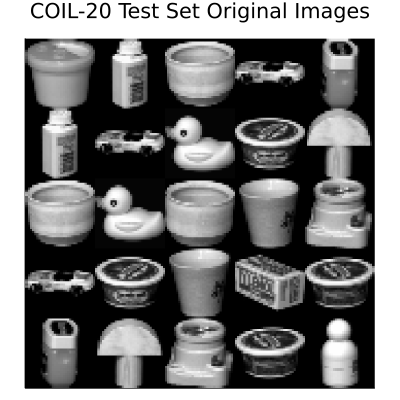

In [42]:
display(plot_image_grid(reshape(x[:,:,26:50],32,32,1,25);grid_x_size = 5, grid_y_size = 5, title = "COIL-20 Test Set Original Images"))
savefig(joinpath("Evaluation_Notebook","coil_test_original"))

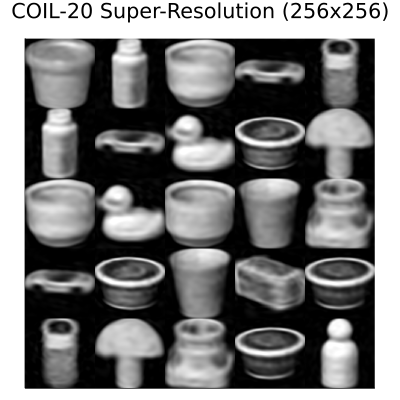

In [43]:
display(plot_image_grid(x_hat_[:,:,:,26:50];grid_x_size = 5, grid_y_size = 5, title = "COIL-20 Super-Resolution (256x256)"))
savefig(joinpath("Evaluation_Notebook","coil_test_super_resolution_256"))